In [29]:
%run Imports.ipynb

In [2]:
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("Model").getOrCreate()

23/04/04 20:08:44 WARN Utils: Your hostname, Yashasvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.232 instead (on interface en0)
23/04/04 20:08:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/04 20:08:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/04 20:08:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/04 20:08:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [7]:
df2 = spark.read.parquet("/Users/yashasvi/Documents/ModelScores/")

In [63]:
df2.columns

['buyer',
 'avg_spent',
 'Score1',
 'number_txns',
 'Score2',
 'num_nftcontract',
 'Score3',
 'num_currency',
 'Score4',
 'avg_duration',
 'Score5']

# Without scores

In [ ]:
assembler = VectorAssembler(inputCols=['avg_spent', 'number_txns', 'num_nftcontract', 'num_currency', 'avg_duration'], outputCol='features')
df = assembler.transform(df)

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(df)

predictions = model.transform(df).select('buyer', 'prediction')


In [ ]:
predictions

In [ ]:
predictions.show()

# With Standardisation

In [5]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

assembler = VectorAssembler(inputCols=['avg_spent', 'number_txns', 'num_nftcontract', 'num_currency', 'avg_duration'], outputCol='features')
df = assembler.transform(df)

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Define the k-means model
kmeans = KMeans(seed=1)

# Define the parameter grid
param_grid = ParamGridBuilder().addGrid(kmeans.k, [3, 5, 7]).addGrid(kmeans.maxIter, [10, 20, 30]).build()

# Define the cross-validator
crossval = CrossValidator(estimator=kmeans,
                          estimatorParamMaps=param_grid,
                          evaluator=ClusteringEvaluator(),
                          numFolds=3,
                          seed=1)

# Fit the cross-validator to the data
cv_model = crossval.fit(df)

# Get the best k-means model from the cross-validator
best_model = cv_model.bestModel

# Add the cluster labels to the DataFrame
predictions = best_model.transform(df).select('buyer', 'prediction')

# Show the results
predictions.show()

# Convert the predictions DataFrame to a pandas DataFrame
pdf = predictions.toPandas()





2023-03-27 09:52:53,852 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:52:58,961 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:02,778 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:05,339 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:07,954 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:10,992 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:13,161 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:15,817 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:19,000 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:23,648 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:26,574 INFO py4j.clientserver Closing down clientserver connection
2023-03-27 09:53:28,782 INFO py4j.clientserver Closing down clientserver con

+--------------------+----------+
|               buyer|prediction|
+--------------------+----------+
|\x000000105de91f6...|         0|
|\x0000005c7dc69d4...|         0|
|\x000004302f29bb0...|         0|
|\x000091892804f65...|         0|
|\x0001859725d8ad5...|         0|
|\x0002b3c47b844a0...|         0|
|\x0002cf540a528d8...|         2|
|\x0007e5de984addb...|         0|
|\x0008a057d19557b...|         0|
|\x000c431bcc7a128...|         0|
|\x000c5406d0de59c...|         0|
|\x001181d93e56aab...|         1|
|\x0011a60755d716e...|         0|
|\x0012228d19a7c7c...|         0|
|\x00138c7f17bc5bd...|         0|
|\x0014492edc0179d...|         0|
|\x00157f1fb327e6c...|         0|
|\x0017177f12a5b8e...|         0|
|\x00197885801973f...|         0|
|\x001cd047fa72ee0...|         0|
+--------------------+----------+
only showing top 20 rows



In [6]:
predictions.select("prediction").distinct().collect()

[Row(prediction=1), Row(prediction=2), Row(prediction=0)]

# Extracting features in Vector

In [42]:
df2.count()

186035

In [47]:
df2.columns

['buyer',
 'avg_spent',
 'Score1',
 'number_txns',
 'Score2',
 'num_nftcontract',
 'Score3',
 'num_currency',
 'Score4',
 'avg_duration',
 'Score5']

In [12]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=[
 'Score1',
 'Score2',
 'Score3',
 'Score4',
 'Score5'], outputCol='features')
assembled_data=assemble.transform(df2)
# assembled_data.show(2)

# ClusteringEvaluator for silhouette_scores

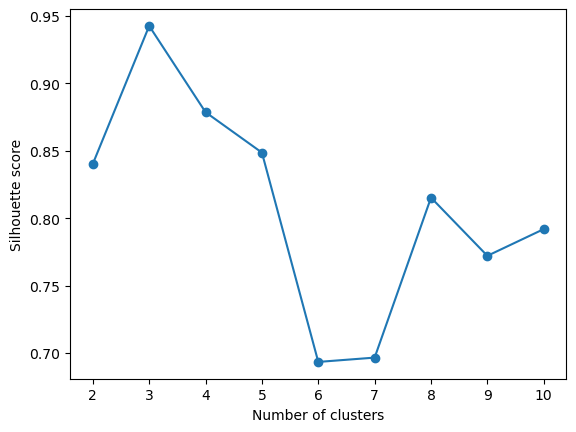

In [64]:
min_clusters = 2
max_clusters = 10
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')
# compute the Silhouette score for each number of clusters
silhouette_scores = []
for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(featuresCol='features', k=n_clusters)
    model = kmeans.fit(assembled_data)
    output = model.transform(assembled_data)
    silhouette_score = evaluator.evaluate(output)
    silhouette_scores.append(silhouette_score)

# plot the Silhouette score vs. number of clusters
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

# best_k = np.argmax(silhouette_scores) + min_clusters - 1
# if best_k == min_clusters or best_k == max_clusters:
#     # The maximum is at the edge of the plot, so return it
#     optimal_n_clusters = best_k
# else:
#     # Check the neighboring values of k
#     prev_score = silhouette_scores[best_k - min_clusters]
#     next_score = silhouette_scores[best_k - min_clusters + 2]
#     if prev_score > silhouette_scores[best_k - min_clusters + 1] or next_score > silhouette_scores[best_k - min_clusters + 1]:
#         # A neighboring value has a higher score, so return the index of the maximum
#         optimal_n_clusters = np.argmax(silhouette_scores) + min_clusters - 1
#     else:
#         # The maximum is the first local maximum
#         optimal_n_clusters = best_k

# print('Optimal number of clusters:', optimal_n_clusters)



In [65]:
local_maxima = []
for i in range(1, len(silhouette_scores)-1):
    if silhouette_scores[i] > silhouette_scores[i-1] and silhouette_scores[i] > silhouette_scores[i+1]:
        local_maxima.append((i, silhouette_scores[i]))
        
# Print local maxima
print("Local maxima:")
for i, score in local_maxima:
    print("Cluster size:", i, "Score:", score)

Local maxima:
Cluster size: 1 Score: 0.9425695117644333
Cluster size: 6 Score: 0.8152388752379949


In [66]:
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(assembled_data)
output = model.transform(assembled_data)

In [45]:
output.select('buyer', 'prediction').show()

+--------------------+----------+
|               buyer|prediction|
+--------------------+----------+
|\x000000000002e33...|         0|
|\x00000000009a418...|         2|
|\x0000396ed2931b1...|         0|
|\x0000a574f2030ff...|         0|
|\x000199cb7dfae39...|         0|
|\x00031a9829a11ef...|         1|
|\x00063ddb30be7bc...|         0|
|\x0006c3a51d493fd...|         0|
|\x0007796d3b5bae6...|         0|
|\x000a774b028e05a...|         0|
|\x0010108d287e168...|         0|
|\x00110e09134aec0...|         0|
|\x0011843e79d0c1d...|         0|
|\x00121a3d3470a11...|         0|
|\x00125c14f990107...|         1|
|\x00175dc0780e23d...|         0|
|\x0017740df8cd52a...|         0|
|\x00192821ac5aa99...|         0|
|\x001b1e09360cdcc...|         0|
|\x001cd703bddb3df...|         0|
+--------------------+----------+
only showing top 20 rows



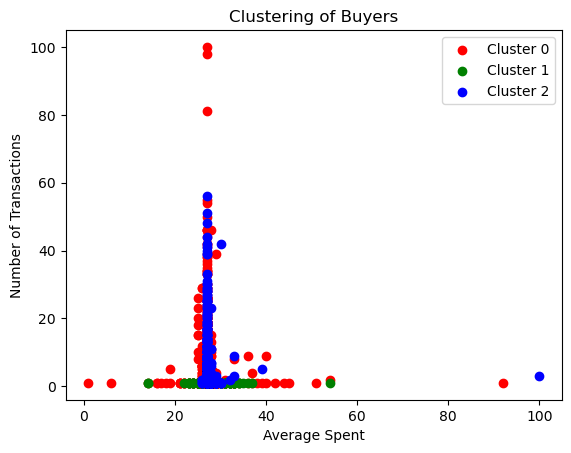

In [57]:
colors = ['red', 'green', 'blue']
output_p = output.toPandas()
for i in range(3):
    cluster_i = output_p[output_p['prediction'] == i]
    plt.scatter(cluster_i['Score1'], cluster_i['Score2'], color=colors[i], label=f'Cluster {i}')
    
plt.xlabel('Average Spent')
plt.ylabel('Number of Transactions')
plt.title('Clustering of Buyers')
plt.legend()
plt.show()


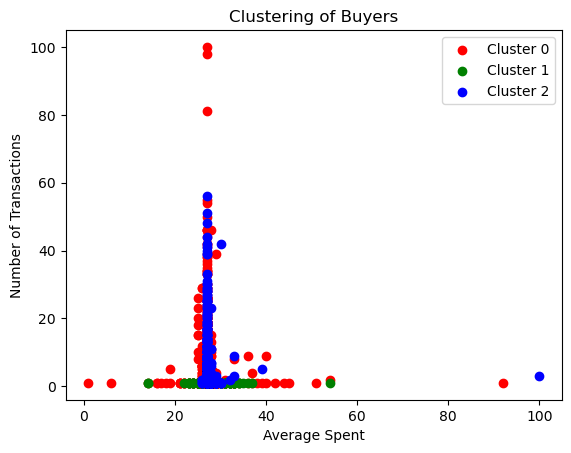

In [58]:
colors = ['red', 'green', 'blue']
output_p = output.toPandas()
for i in range(3):
    cluster_i = output_p[output_p['prediction'] == i]
    plt.scatter(cluster_i['Score1'], cluster_i['Score3'], color=colors[i], label=f'Cluster {i}')
    
plt.xlabel('Average Spent')
plt.ylabel('Number of Transactions')
plt.title('Clustering of Buyers')
plt.legend()
plt.show()

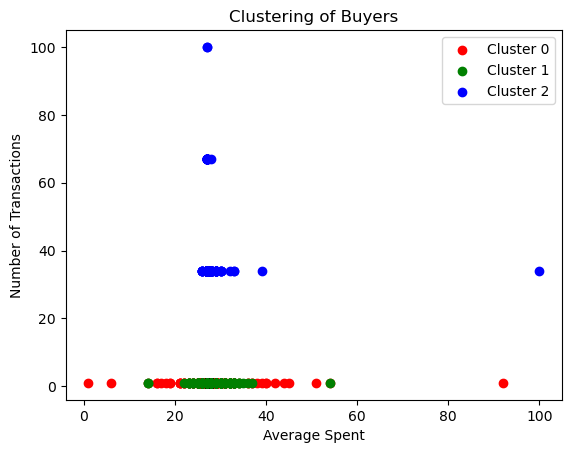

In [59]:
colors = ['red', 'green', 'blue']
output_p = output.toPandas()
for i in range(3):
    cluster_i = output_p[output_p['prediction'] == i]
    plt.scatter(cluster_i['Score1'], cluster_i['Score4'], color=colors[i], label=f'Cluster {i}')
    
plt.xlabel('Average Spent')
plt.ylabel('Number of Transactions')
plt.title('Clustering of Buyers')
plt.legend()
plt.show()

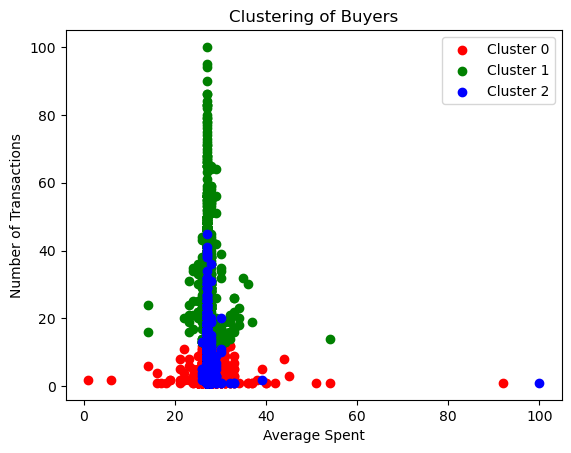

In [60]:
colors = ['red', 'green', 'blue']
output_p = output.toPandas()
for i in range(3):
    cluster_i = output_p[output_p['prediction'] == i]
    plt.scatter(cluster_i['Score1'], cluster_i['Score5'], color=colors[i], label=f'Cluster {i}')
    
plt.xlabel('Average Spent')
plt.ylabel('Number of Transactions')
plt.title('Clustering of Buyers')
plt.legend()
plt.show()

In [61]:
output_p.columns

Index(['buyer', 'avg_spent', 'Score1', 'number_txns', 'Score2',
       'num_nftcontract', 'Score3', 'num_currency', 'Score4', 'avg_duration',
       'Score5', 'features', 'prediction'],
      dtype='object')

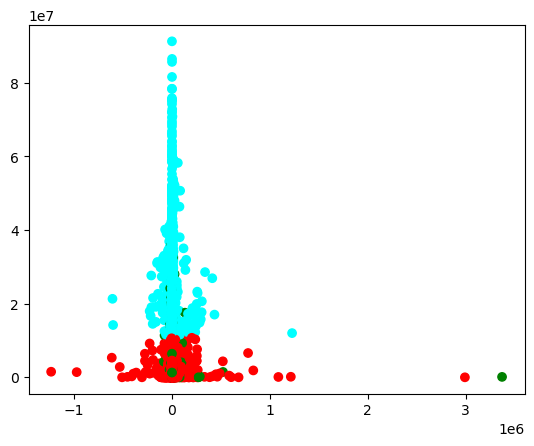

In [62]:
colors = {0: 'red', 1: 'aqua', 2:'green'}

plt.scatter(output_p.avg_spent, output_p.avg_duration, c=output_p.prediction.map(colors))